<a href="https://colab.research.google.com/github/EcoCommons-Australia-2024-2026/notebooks/blob/main/notebooks/raster_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![EcoCommons Notebooks Banner](https://drive.google.com/uc?id=1UprYJGmRUZyS20lQrODTiHbl2Ywvl2dW)


# Species Distribution Analysis - Environmental Data Preparation (Rasters)

---
Author details: Xiang Zhao

Editor details:

Contact details: support@ecocommons.org.au

Copyright statement: This script is the product of the EcoCommons platform.   
                     Please refer to the EcoCommons website for more details: https://www.ecocommons.org.au/

Date: Nov 2024  

---

# Script and data info:

This notebook, developed by the EcoCommons team, showcases how to download, and process both conitunous and categorical environmental datasets that in the format of rasters to be used for SDM.

**Workflow Overview**:

- Initial Setup:
        Set the working directory and load necessary R packages (dismo, ggplot2, raster, googledrive, sp, dplyr, terra).
        Create directory to store raw data files.

- Data Download:
        Download continuous environmental dataset from WorldClim.
        Download categorical environmental dataset from our Google Drive.

- Data Processing:
       Reproject environmental datasets to your desired CRS.
       Resample enviromental datasets to a same resolution.
       Crop and mask enviromental datasets to the extent of your study area.

In the near future, this material may form part of comprehensive support materials available to EcoCommons users.

If you have any corrections or suggestions to improve the effeciengy, please [contact the EcoCommons](mailto:support@ecocommons.org.au) team.

![](https://raw.githubusercontent.com/EcoCommons-Australia-2024-2026/ec-notebook_site/main/images/EC_section_break.png)



# Introduction

## 1. Environmental variables

In Species Distribution Modeling (SDM), **environmental variables** are factors that influence where a species can live. These include:

-   **Climatic Variables**: Temperature, precipitation.

-   **Topographic Variables**: Elevation, slope.

-   **Soil Variables**: Soil pH, texture.

-   **Vegetation Variables**: Land cover type, canopy cover.

-   **Hydrological Variables**: Distance to water bodies, soil moisture.

-   **Biotic Variables**: Presence of prey, competitors.

-   **Anthropogenic Variables**: Land use, human impact.

These variables help explain and predict a species' habitat suitability based on environmental conditions.

## 2. Raster

**Raster data** is a type of spatial data used to represent continuous surfaces, like environmental layers (e.g., elevation, temperature) in grids or cells. Each cell (pixel) has a value that represents information about that area.

**Important Characteristics**:

-   **Resolution**: Size of each cell, determining data detail (e.g., 10m x 10m cells).

-   **Extent**: Geographic area covered by the raster.

-   **Coordinate Reference System (CRS)**: Defines the spatial reference of the raster for location accuracy.

-   **Data Type**: Can be **continuous** (e.g., temperature) or **categorical** (e.g., land cover type).

These characteristics impact how raster data is interpreted and used in analyses like SDM.

**To make extract the value of raster data, we always want our raster data has the same resolution, extend, and CRS.**

## 3. Categorical and Continuous data

In environmental modeling, **environmental variables** can be classified as **categorical** or **continuous**:

**Categorical Data**

-   Represents discrete classes or categories.

-   **Examples**:

    -   **Land Cover Type**: Forest, grassland, urban.

    -   **Soil Type**: Sandy, clay, loam.

    -   **Vegetation Type**: Different plant communities.

**Continuous Data**

-   Represents data with a smooth gradient, measurable values.

-   **Examples**:

    -   **Temperature**: Annual mean temperature.

    -   **Precipitation**: Monthly or annual rainfall.

    -   **Elevation**: Height above sea level in meters.

Categorical data is useful for distinct classifications, while continuous data is used for variables that change gradually across the landscape. Both types are important for predicting species distributions.

![](https://raw.githubusercontent.com/EcoCommons-Australia-2024-2026/ec-notebook_site/main/images/EC_section_break.png)


# Practice

## 1. Set working directory and make a folder to store data.

In [1]:
# Set Workspace as the current working directory
workspace <- getwd()

env_data_dir <- file.path(workspace, "env_data")

# Create the 'raw_data' directory if it doesn't exist
if (!dir.exists(env_data_dir)) {
  dir.create(env_data_dir, recursive = TRUE)
  cat("Directory 'env_data' created successfully.\n")
} else {
  cat("Directory 'env_data' already exists.\n")
}


Directory 'env_data' created successfully.


## 2. Install and load essential libraries.

*This process might last 15 - 30 mins.*

In [2]:
# List of packages to check, install if needed, and load
packages <- c("dplyr", "terra", "sf", "googledrive", "ggplot2")

# Install missing packages and load them
for (pkg in packages) {
  if (!pkg %in% installed.packages()[, "Package"]) {
    install.packages(pkg)
  }
  library(pkg, character.only = TRUE)
}



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

terra 1.7.83

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’


Linking to GEOS 3.11.1, GDAL 3.6.4, PROJ 9.1.1; sf_use_s2() is TRUE



## 3. Download Environmental Data

Environmental variables are downloaded from both WorldClim and Google Drive, and stored in GeoTIFF format.

In [3]:
library(googledrive)
drive_deauth()  # Access public files without authentication


# Define Google Drive file IDs and corresponding local file paths for environmental variables
file_ids <- list(
  env_var_1 = "1EA_lberXjNI3_RRM0mbAdDvVDTFL2tW3", # Continuous Environmental Variable 1, Bioclim 01
  env_var_2 = "1PO1TAQp-ND4olSgIQ29wjexMOQnhXkku", # Continuous Environmental Variable 2, Bioclim 02
  env_var_3 = "1BSEuphUV-qqR-gnA9HPZ1qKGLyJfLagC", # Continuous Environmental Variable 3, Bioclim 03
  env_var_4 = "1fCI5D_AGg2nhU75A-9WX7MspcrQYMp7f", # Continuous Environmental Variable 4, Bioclim 04
  env_var_5 = "1yWmJ9fKFPZQoV_XTRIWABV_gaF-wexzZ", # Continuous Environmental Variable 5, Bioclim 05
  env_var_cat_1 = "1WzBKghFdG67C_LMeOmi9a1A12wjrd9wo" # Categorical Environmental Variable 1, Land use of Australia
)


# Define local file paths for each environmental variable
file_paths <- list(
  env_var_1 = file.path(workspace, "env_data", "env_var_1.tif"),
  env_var_2 = file.path(workspace, "env_data", "env_var_2.tif"),
  env_var_3 = file.path(workspace, "env_data", "env_var_3.tif"),
  env_var_4 = file.path(workspace, "env_data", "env_var_4.tif"),
  env_var_5 = file.path(workspace, "env_data", "env_var_5.tif"),
  env_var_cat_1 = file.path(workspace, "env_data", "env_var_cat_1.tif")
)

# Function to download individual files with progress messages
download_file <- function(file_id, file_path) {
  cat("Downloading:", basename(file_path), "...\n")
  drive_download(as_id(file_id), path = file_path, overwrite = TRUE)
  cat("Downloaded:", basename(file_path), "\n")
}

# Download each environmental variable file
cat("Downloading environmental variable files...\n")
invisible(mapply(download_file, file_ids, file_paths))

# Confirm the files have been downloaded
downloaded_files <- list.files(file.path(workspace, "env_data"), recursive = TRUE)
cat("Downloaded files:\n", downloaded_files, "\n")


Downloading: env_var_1.tif ...


File downloaded:

• wc2.1_2.5m_bioclim_01.tif <id: 1EA_lberXjNI3_RRM0mbAdDvVDTFL2tW3>

Saved locally as:

• /content/env_data/env_var_1.tif



Downloaded: env_var_1.tif 
Downloading: env_var_2.tif ...


File downloaded:

• wc2.1_2.5m_bioclim_02.tif <id: 1PO1TAQp-ND4olSgIQ29wjexMOQnhXkku>

Saved locally as:

• /content/env_data/env_var_2.tif



Downloaded: env_var_2.tif 
Downloading: env_var_3.tif ...


File downloaded:

• wc2.1_2.5m_bioclim_03.tif <id: 1BSEuphUV-qqR-gnA9HPZ1qKGLyJfLagC>

Saved locally as:

• /content/env_data/env_var_3.tif



Downloaded: env_var_3.tif 
Downloading: env_var_4.tif ...


File downloaded:

• wc2.1_2.5m_bioclim_04.tif <id: 1fCI5D_AGg2nhU75A-9WX7MspcrQYMp7f>

Saved locally as:

• /content/env_data/env_var_4.tif



Downloaded: env_var_4.tif 
Downloading: env_var_5.tif ...


File downloaded:

• wc2.1_2.5m_bioclim_05.tif <id: 1yWmJ9fKFPZQoV_XTRIWABV_gaF-wexzZ>

Saved locally as:

• /content/env_data/env_var_5.tif



Downloaded: env_var_5.tif 
Downloading: env_var_cat_1.tif ...


File downloaded:

• land_use_Australia_6class_cat.tif <id: 1WzBKghFdG67C_LMeOmi9a1A12wjrd9wo>

Saved locally as:

• /content/env_data/env_var_cat_1.tif



Downloaded: env_var_cat_1.tif 
Downloaded files:
 env_var_1.tif env_var_2.tif env_var_3.tif env_var_4.tif env_var_5.tif env_var_cat_1.tif 


## 4. Load and Process Environmental Data

All raster files are loaded and reprojected if necessary to ensure consistency.


In [4]:
# Load all rasters and store in a list
rasters <- lapply(file_paths, rast)


# Sometimes, when you upload a raster file (such as a GeoTIFF) to Google Drive and then open it in Google Colab, it may lose its categorical (factor) properties due to how terra or other spatial libraries interpret the file upon reloading. Rasters saved as categorical may be stored with integer values rather than explicit factor levels in the file, meaning they need to be redefined as factors when reloaded.

rasters[[6]] <- as.factor(rasters[[6]])

# Check if each raster is categorical or continuous
for (i in seq_along(rasters)) {
  if (is.factor(rasters[[i]])) {
    cat("Raster", i, "is categorical.\n")
  } else {
    cat("Raster", i, "is continuous.\n")
  }
}

Raster 1 is continuous.
Raster 2 is continuous.
Raster 3 is continuous.
Raster 4 is continuous.
Raster 5 is continuous.
Raster 6 is categorical.


## 5. Download and Load Australian Boundary Shapefile

In [5]:
library(googledrive)

# De-authenticate Google Drive to access public files
drive_deauth()

# Folder ID for the Australian polygon shapefile
aus_folder_id <- "1rzNHthnQQXVulocKkB5i7v2dObqKMP11"

# Define the local directory to save the shapefile components
shapefile_dir <- file.path(workspace, "env_data", "aus_shapefile")
dir.create(shapefile_dir, showWarnings = FALSE, recursive = TRUE)

# List all files in the shapefile folder on Google Drive
files_in_folder <- drive_ls(as_id(aus_folder_id))

# Download each file in the folder
cat("Downloading shapefile components...\n")
for (i in 1:nrow(files_in_folder)) {
  file_name <- files_in_folder$name[i]
  cat("Downloading:", file_name, "...\n")
  drive_download(files_in_folder$id[i], path = file.path(shapefile_dir, file_name), overwrite = TRUE)
}

cat("Shapefile components downloaded to:", shapefile_dir, "\n")

# Load necessary library for handling shapefiles
library(terra)

# Load the shapefile using the components in the downloaded directory
shapefile_path <- list.files(shapefile_dir, pattern = "\\.shp$", full.names = TRUE)

# Load the Australian boundary as an sf object and convert to EPSG 4326
australia_boundary <- st_read(shapefile_path)
australia_boundary <- st_transform(australia_boundary, crs = 4326)

class(australia_boundary)

Downloading: AUS_2021_AUST_GDA2020.xml ...


File downloaded:

• AUS_2021_AUST_GDA2020.xml <id: 1BxMyIxENdWJ2RiZxK_8Ay_0r2Uvad5Wd>

Saved locally as:

• /content/env_data/aus_shapefile/AUS_2021_AUST_GDA2020.xml



Downloading: AUS_2021_AUST_GDA2020.shx ...


File downloaded:

• AUS_2021_AUST_GDA2020.shx <id: 1wfSxFsmgK4V44f4ZJhYy3V6wL16YpVWe>

Saved locally as:

• /content/env_data/aus_shapefile/AUS_2021_AUST_GDA2020.shx



Downloading: AUS_2021_AUST_GDA2020.dbf ...


File downloaded:

• AUS_2021_AUST_GDA2020.dbf <id: 1gdWxQ5aOB_KuejlHn254K7RwdtDR2N8f>

Saved locally as:

• /content/env_data/aus_shapefile/AUS_2021_AUST_GDA2020.dbf



Downloading: AUS_2021_AUST_GDA2020.prj ...


File downloaded:

• AUS_2021_AUST_GDA2020.prj <id: 1Fi9K9mWOpvksSkH0CGJN9XlKf8-1LjSj>

Saved locally as:

• /content/env_data/aus_shapefile/AUS_2021_AUST_GDA2020.prj



Downloading: AUS_2021_AUST_GDA2020.shp ...


File downloaded:

• AUS_2021_AUST_GDA2020.shp <id: 1ZWGQYHbygM-MCFyON76FXwj7uHwJnpxH>

Saved locally as:

• /content/env_data/aus_shapefile/AUS_2021_AUST_GDA2020.shp



Shapefile components downloaded to: /content/env_data/aus_shapefile 
Reading layer `AUS_2021_AUST_GDA2020' from data source 
  `/content/env_data/aus_shapefile/AUS_2021_AUST_GDA2020.shp' 
  using driver `ESRI Shapefile'
replacing null geometries with empty geometries
Simple feature collection with 2 features and 6 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 96.81695 ymin: -43.7405 xmax: 167.998 ymax: -9.142163
Geodetic CRS:  GDA2020


[1] "sf"         "data.frame"

## 6. Plot the study area, Australian Boundary

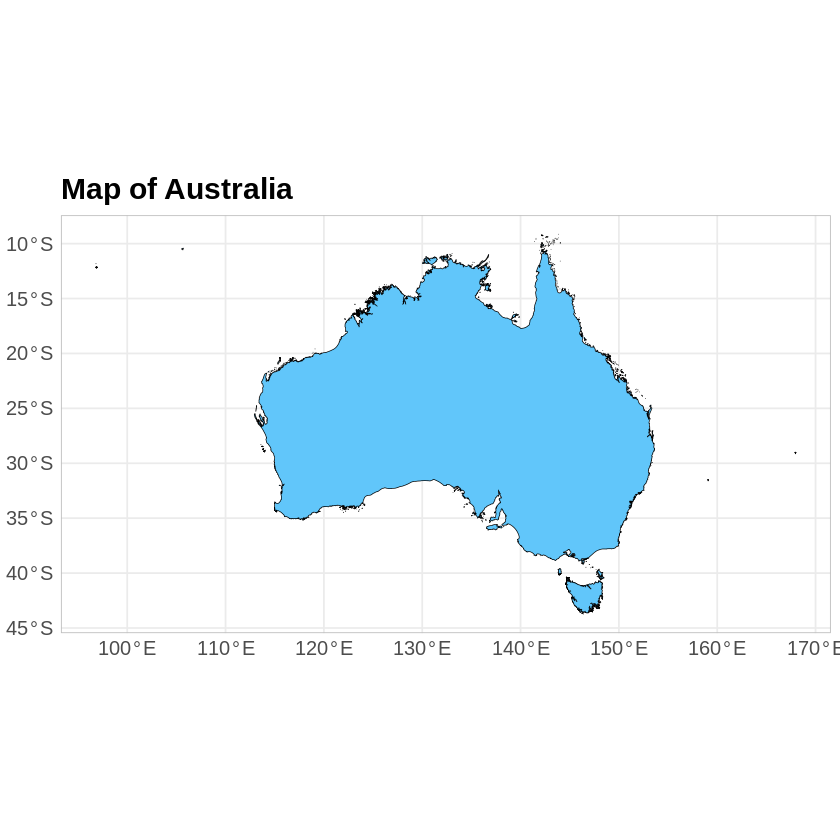

In [6]:

# Plot the Australia boundary using ggplot2
ggplot(data = australia_boundary) +
  geom_sf(fill = "#61c6fa", color = "black") +  # Fill with light blue and outline in black
  labs(title = "Map of Australia") +
  theme_minimal() +
  theme(plot.title = element_text(size = 18, face = "bold"),
        axis.title.x = element_text(size = 12),
        axis.title.y = element_text(size = 12),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12),
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 12),
        panel.border = element_rect(colour = "gray", fill = NA, linewidth = 0.5))

## 7. Show Resolution, Extent, and CRS of Raster and Study Area

Show the resolution, extent, and crs of each raster, also the extent and crs of the study area shapefile.

In [7]:

# Get and print the extent of the Australian boundary vector
australia_extent <- ext(australia_boundary)
cat("Extent of Australia boundary:\n")
print(australia_extent)

# Get and print the CRS of the Australian boundary vector
australia_crs <- crs(australia_boundary)
cat("CRS of Australia boundary:\n")
print(australia_crs)

Extent of Australia boundary:
SpatExtent : 96.8169516292395, 167.99803924286, -43.7404965718585, -9.14216252238993 (xmin, xmax, ymin, ymax)
CRS of Australia boundary:
[1] "GEOGCRS[\"WGS 84\",\n    ENSEMBLE[\"World Geodetic System 1984 ensemble\",\n        MEMBER[\"World Geodetic System 1984 (Transit)\"],\n        MEMBER[\"World Geodetic System 1984 (G730)\"],\n        MEMBER[\"World Geodetic System 1984 (G873)\"],\n        MEMBER[\"World Geodetic System 1984 (G1150)\"],\n        MEMBER[\"World Geodetic System 1984 (G1674)\"],\n        MEMBER[\"World Geodetic System 1984 (G1762)\"],\n        MEMBER[\"World Geodetic System 1984 (G2139)\"],\n        ELLIPSOID[\"WGS 84\",6378137,298.257223563,\n            LENGTHUNIT[\"metre\",1]],\n        ENSEMBLEACCURACY[2.0]],\n    PRIMEM[\"Greenwich\",0,\n        ANGLEUNIT[\"degree\",0.0174532925199433]],\n    CS[ellipsoidal,2],\n        AXIS[\"geodetic latitude (Lat)\",north,\n            ORDER[1],\n            ANGLEUNIT[\"degree\",0.0174532925199433

In [8]:

# Iterate over the rasters to show resolution, extent, and CRS
for (i in seq_along(rasters)) {
  cat("\nRaster", i, ":\n")

  # Show the resolution
  res_val <- res(rasters[[i]])
  cat("Resolution (x, y):", res_val[1], ",", res_val[2], "\n")

  # Show the extent - Modified to handle S4 object
  ext_val <- ext(rasters[[i]])
  cat("Extent:", as.character(ext_val), "\n") # Convert ext_val to character

  # Show the CRS
  crs_val <- crs(rasters[[i]])
  cat("CRS:", crs_val, "\n")
}


Raster 1 :
Resolution (x, y): 0.04166667 , 0.04166667 
Extent: ext(-180, 180, -90, 90) 
CRS: GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],


## 8. Reproject Raster to WGS 84 if Needed

In [9]:
library(terra)

# Function to check CRS and reproject to WGS 84 if needed
reproject_if_needed <- function(raster, is_categorical = FALSE) {
  wgs84_crs <- "EPSG:4326"  # Define WGS 84 CRS using EPSG code

  # Check if the CRS is already WGS 84
  if (!identical(crs(raster), wgs84_crs)) {
    # Choose the appropriate method based on raster type
    method <- if (is_categorical) "near" else "bilinear"
    message("Reprojecting raster to WGS 84 using method: ", method)

    # Reproject raster to WGS 84 CRS
    raster <- project(raster, wgs84_crs, method = method)

    # Convert to factor again if categorical to ensure category levels are preserved
    if (is_categorical) {
      raster <- as.factor(raster)
    }
  }

  return(raster)
}

# Define the categorical raster indices
categorical_indices <- c(6)  # Adjust if there are other categorical rasters

# Apply the function to each raster in the list
rasters_reprojected <- lapply(seq_along(rasters), function(i) {
  is_categorical <- i %in% categorical_indices
  reproject_if_needed(rasters[[i]], is_categorical = is_categorical)
})

# Print CRS of each reprojected raster to verify
for (i in seq_along(rasters_reprojected)) {
  cat("\nRaster", i, "CRS:\n")
  print(crs(rasters_reprojected[[i]]))
}


Reprojecting raster to WGS 84 using method: bilinear

Reprojecting raster to WGS 84 using method: bilinear

Reprojecting raster to WGS 84 using method: bilinear

Reprojecting raster to WGS 84 using method: bilinear

Reprojecting raster to WGS 84 using method: bilinear

Reprojecting raster to WGS 84 using method: near



                                          
Raster 1 CRS:
[1] "GEOGCRS[\"WGS 84\",\n    ENSEMBLE[\"World Geodetic System 1984 ensemble\",\n        MEMBER[\"World Geodetic System 1984 (Transit)\"],\n        MEMBER[\"World Geodetic System 1984 (G730)\"],\n        MEMBER[\"World Geodetic System 1984 (G873)\"],\n        MEMBER[\"World Geodetic System 1984 (G1150)\"],\n        MEMBER[\"World Geodetic System 1984 (G1674)\"],\n        MEMBER[\"World Geodetic System 1984 (G1762)\"],\n        MEMBER[\"World Geodetic System 1984 (G2139)\"],\n        ELLIPSOID[\"WGS 84\",6378137,298.257223563,\n            LENGTHUNIT[\"metre\",1]],\n        ENSEMBLEACCURACY[2.0]],\n    PRIMEM[\"Greenwich\",0,\n        ANGLEUNIT[\"degree\",0.0174532925199433]],\n    CS[ellipsoidal,2],\n        AXIS[\"geodetic latitude (Lat)\",north,\n            ORDER[1],\n            ANGLEUNIT[\"degree\",0.0174532925199433]],\n        AXIS[\"geodetic longitude (Lon)\",east,\n            ORDER[2],\n            ANGLEUNIT[\"degree\",

In [10]:
# Check if each raster is categorical or continuous
for (i in seq_along(rasters)) {
  if (is.factor(rasters[[i]])) {
    cat("Raster", i, "is categorical.\n")
  } else {
    cat("Raster", i, "is continuous.\n")
  }
}

Raster 1 is continuous.
Raster 2 is continuous.
Raster 3 is continuous.
Raster 4 is continuous.
Raster 5 is continuous.
Raster 6 is categorical.


## 9. Resample Rasters to Match the Finest Resolution

In [11]:
# Determine the finest resolution among the reprojected rasters
resolutions <- sapply(rasters_reprojected, function(r) res(r)[1] * res(r)[2])
finest_index <- which.min(resolutions)
finest_raster <- rasters_reprojected[[finest_index]]

# Resample each raster to match the finest resolution
rasters_resampled <- lapply(seq_along(rasters_reprojected), function(i) {
  raster <- rasters_reprojected[[i]]

  # Determine resampling method based on the type of raster (categorical vs continuous)
  if (i == 6) {  #the 6th raster is the categorical one
    message("Resampling categorical raster to match the finest resolution using 'nearest' method.")
    raster <- resample(raster, finest_raster, method = "near")  # Use 'near' for categorical data
  } else {
    message("Resampling continuous raster to match the finest resolution using 'bilinear' method.")
    raster <- resample(raster, finest_raster, method = "bilinear")  # Use 'bilinear' for continuous data
  }

  return(raster)
})

Resampling continuous raster to match the finest resolution using 'bilinear' method.



Resampling continuous raster to match the finest resolution using 'bilinear' method.



Resampling continuous raster to match the finest resolution using 'bilinear' method.



Resampling continuous raster to match the finest resolution using 'bilinear' method.



Resampling continuous raster to match the finest resolution using 'bilinear' method.



Resampling categorical raster to match the finest resolution using 'nearest' method.



## 10. Crop and Mask Raster to the Study Area

In [12]:
# Reproject the Australian boundary vector to WGS 84
wgs84_crs <- "EPSG:4326"

australia_boundary_vect <- vect(australia_boundary)

australia_boundary_vect_wgs84 <- project(australia_boundary_vect, wgs84_crs)

# Crop and mask each resampled raster to the extent of Australia
cropped_masked_rasters <- lapply(rasters_resampled, function(raster) {
  # Crop the raster to the extent of Australia
  cropped_raster <- crop(raster, australia_boundary_vect_wgs84)
  # Mask the raster with the Australia boundary to keep only data within Australia
  masked_raster <- mask(cropped_raster, australia_boundary_vect_wgs84)
  return(masked_raster)
})


when using stack() to stack rasters in R, it is important that all the rasters meet the following conditions to ensure correct stacking:

1. **Same Extent;**
2. **Same Coordinate Reference System (CRS); and**
3. **Same cell resolution (pixel size).**

## 11. Stack and Save Raster

class       : SpatRaster 
dimensions  : 14113, 22774, 6  (nrow, ncol, nlyr)
resolution  : 0.002451532, 0.002451532  (x, y)
extent      : 105.7046, 161.5358, -43.74011, -9.141636  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
sources     : spat_a666bf1971_166_aYjuhHgkOkYNCZW.tif  
              spat_a61bc0fa63_166_bTGLeWgikzRi5uE.tif  
              spat_a61cdcaab9_166_rG2neQku8ByG59H.tif  
              ... and 3 more source(s)
names       : env_var_1, env_var_2, env_var_3, env_var_4, env_var_5, Category 
min values  :  4.272866,  3.591667,  31.50585,  53.13949,  15.60910,        1 
max values  : 29.350683, 17.464588,  77.26542, 682.58344,  42.34991,        6 


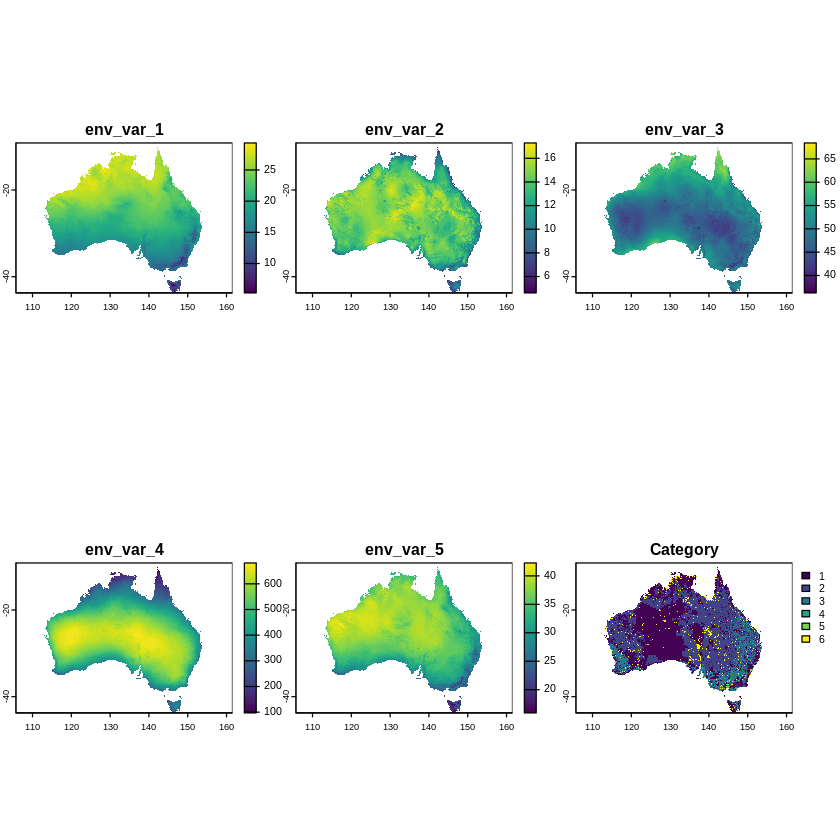

In [13]:
# Stack the cropped and masked rasters together
raster_stack <- do.call(c, cropped_masked_rasters)

# Print summary to verify the stack
print(raster_stack)

# Plot each layer to visually verify the raster stack
plot(raster_stack)

# Save the raster stack to a GeoTIFF file
writeRaster(raster_stack, filename = "stacked_raster.tif", overwrite = TRUE)

![](https://raw.githubusercontent.com/EcoCommons-Australia-2024-2026/ec-notebook_site/main/images/EC_section_break.png)


EcoCommons Australia partners with the Australian Research Data Commons (ARDC), which is supported by funding from the National Collaborative Research Infrastructure Strategy (NCRIS) [https://doi.org/10.47486/PL108. ](https://doi.org/10.47486/PL108)

<div align="center">

<br><br>

**Our partner**

</div>

![](https://raw.githubusercontent.com/EcoCommons-Australia-2024-2026/ec-notebook_site/main/images/partners_logos.png)

### **How to Cite EcoCommons**

If you use EcoCommons in your research, please cite the platform as follows:

> EcoCommons Australia 2024. *EcoCommons Australia – a collaborative commons for ecological and environmental modelling*, Queensland Cyber Infrastructure Foundation, Brisbane, Queensland. Available at: <https://data–explorer.app.ecocommons.org.au/> (Accessed: MM DD, YYYY). https://doi.org/10.47486/PL108

You can download the citation file for EcoCommons Australia here: [Download the BibTeX file](reference.bib)